# Map algebra

Map algebra is often used as an umbrella term for conducting various mathematical and logical operations, as well as spatial analysis operations, based on raster data. These techniques were first developed by Dana Tomlin in the 1970's ({cite}`Tomlin1990`) and they have since then been a fundamental part of raster data analysis in GIS. Map algebra provides a set of operators that can be applied to a single or multiple raster layers to produce a new raster layer. For instance, you can do basic mathematical calculations (multiply, sum, divide, etc.) between multiple raster layers that are central operations for map overlay analysis, or conduct mathematical operations on a single raster to compute values based on a given neighborhood. The latter can be used e.g. to detect hot spots based on the pixel values, in which high values are surrounded by other high values. Map algebra is widely used in terrain analysis, land suitability modeling, hydrological modeling, and environmental assessments. By integrating spatial data with mathematical functions, it enables powerful spatial decision-making.

The operations of map algebra can be divided into different categories:

- **Focal operations** compute values based on a specified neighborhood (e.g. 3x3 window) on a given raster layer.
- **Local operations** apply functions on a cell-by-cell basis between multiple raster layers.
- **Global operations** use all raster cells in computations to calculate e.g. statistical summaries.
- **Zonal operations** analyze values within defined zones, such as calculating average elevation within a watershed.
- **Incremental operations** apply iterative calculations or cumulative functions over space or time (e.g. cumulative cost surfaces).

There are various Python libraries that can be used for map algebra. Here, we are focusing on `xarray`, `xarray-spatial` and `xvec` libraries that provide numerous useful functionalities to conduct focal, local, global, zonal and incremental operations using raster data. In the following, we will apply map algebra to Digital Elevation Model (DEM) raster data obtained from Eastern Finland to gain knowledge of the topography in this area. In addition, we will learn how it is possible to conduct suitability analysis to find an optimal location to build a new summer house based on specific criteria, and how to conduct path finding on raster data to find least-cost route between two locations across the raster cost surface. 

## Focal operations

A focal function operates on a cell and its neighboring cells within a defined window (e.g., 3x3 or 5x5). The output value for each cell is derived by applying a mathematical or statistical operation to the values within that neighborhood. **Figure 7.xx** shows an example of a *focal sum* that is summing the input layer values to produce the pixel value in the output layer based on 3x3 window. For instance at the highlighted position (circled) on the right, the pixel will get a value 50 after summing the center pixel and the surrounding pixels in the input layer (left). In a similar manner, the 3x3 moving window is applied to all pixels in the images which creates the output raster seen on the right. Do you notice how the values at the edges of the output layer tend to be smaller? This happens because at the edges of the raster the 3x3 moving window moves "outside" of the raster area and thus has fewer input pixels that can be taken into account when doing the calculation. This kind of *{term}`edge effect`* is very typical when working with geographic data and you can deal with the issue by ensuring that the input data covers a bit of extra buffer (i.e. additional pixels) around the area of interest where you conduct the analysis. 

In addition to sum operation, you can apply any mathematical operator to calculate the pixel values, such as `mean`, `median`, `max`, `min`, `std`. Focal operations can be used also to conduct more complex calculations, such as doing edge detection or determining the slope of a terrain which we will learn next.


![_**Figure 7.XX.** Focal operation based on 3x3 window that considers the neighboring cells to all directions to define the cell value in the output raster._In this case, the output value is a sum of all input pixels](../img/focal-sum.png)
_**Figure 7.XX.** Focal operation based on 3x3 window that considers the neighboring cells to all directions to define the cell value in the output raster. In this case, the output value is a sum of all input pixels._

Now as we have learned the basic idea of focal operation, we can move forward to see how we can take advantage of different kind of focal operations to extract relevant information about the landscape (terrain) that can help us to find a suitable place to build a new summer house. Let's start by reading the Digital Elevation Model from a NetCDF file using `xarray`: 

In [1]:
import xarray as xr
import xrspatial
import matplotlib.pyplot as plt

fp = "data/Tuupovaara_DEM.nc"
data = xr.open_dataset(fp, decode_coords="all")
data

<xarray.Dataset> Size: 1MB
Dimensions:      (x: 400, y: 400)
Coordinates:
  * x            (x) float64 3kB 3.69e+06 3.69e+06 3.69e+06 ... 3.7e+06 3.7e+06
  * y            (y) float64 3kB 6.95e+06 6.95e+06 ... 6.94e+06 6.94e+06
    spatial_ref  int64 8B ...
Data variables:
    elevation    (y, x) float64 1MB ...
Attributes:
    AREA_OR_POINT:  Area

The dimensions of our data is 400x400 pixels and there is one data variable (`elevation`) that we can use to calculate various topography related indicators. Let's first plot our data with contour lines to get a sense of how the landscape looks like in Eastern Finland close to Tuupovaara:

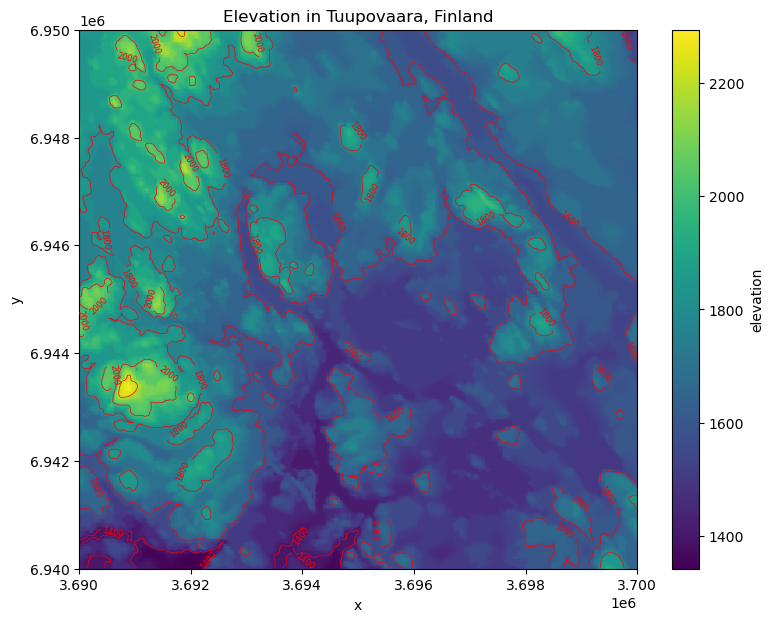

In [2]:
# Plot the elevation values and contours
fig, ax = plt.subplots(figsize=(9, 7))
data["elevation"].plot(ax=ax)
cs = data["elevation"].plot.contour(ax=ax, colors="red", linewidths=0.5)

# Label contours
ax.clabel(cs, cs.levels, inline=True, fontsize=6)
plt.title("Elevation in Tuupovaara, Finland");

_**Figure 7.X.** Elevation surface with contour lines._

### Slope

One of the most useful ways to characterize and get a sense of a given landscape or terrain is to calculate *{term}`slope`*. Slope is a measure of the steepness or incline of the terrain which represents the rate of change in elevation over distance and is typically expressed in degrees or percent. Calculating slope can be done easily using the `xarray-spatial` library's `.slope()` function that takes the `elevation` values as input:

In [3]:
# Calculate slope
data["slope"] = xrspatial.slope(data["elevation"])
data["slope"].values

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,  5.063198 ,  5.2520905, ..., 23.836535 , 31.893763 ,
               nan],
       [       nan,  4.9166656,  5.267519 , ..., 23.46884  , 27.478767 ,
               nan],
       ...,
       [       nan, 18.101492 , 17.874008 , ...,  0.4051356,  0.4051356,
               nan],
       [       nan, 18.568825 , 18.101492 , ...,  0.       ,  0.5729387,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

As output, we have an array where the slope for given pixel is represented in degrees. Slope is a focal operation that is calculated based on a moving window which is the reason that there are some `None` values as well at the edges of the array (i.e. the edge effect is present here). Let's finally visualize the slope to see how the steepness of the terrain varies in our study region:

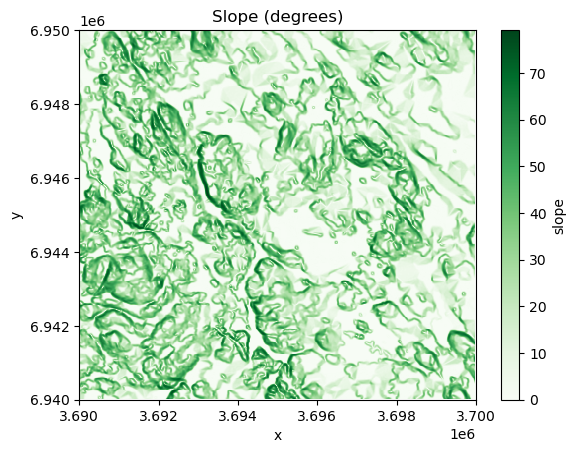

In [4]:
data["slope"].plot(cmap="Greens")
plt.title("Slope (degrees)");

_**Figure 7.X.** Slope in degrees calculated from the elevation data._

As we can see the western areas of the terrain include steep slopes highlighted with dark green color, while the central and eastern areas are more flat which are indicated with lighter tones. 

### Aspect

*{term}`Aspect`* shows the direction that a slope faces. It is measured in degrees from 0° (North) to 360°, and it helps to determine e.g. sunlight exposure, vegetation patterns, and microclimate conditions. Aspect can only be determined for areas that have some level of slope, i.e. flat areas that do not have any degree of change in elevation cannot have aspect either. To calculate aspect, we can use the `.aspect()` function of `xarray-spatial` that takes the elevation data as input:

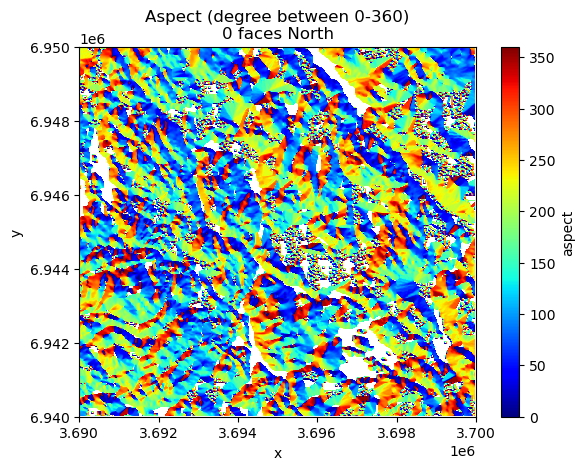

In [5]:
# Calculate aspect
data["aspect"] = xrspatial.aspect(data["elevation"])

# Filter values that are below 0 (areas without aspect defined)
data["aspect"] = data["aspect"].where(data["aspect"] >= 0)
data["aspect"].plot(cmap="jet")
plt.title("Aspect (degree between 0-360)\n0 faces North");

_**Figure 7.X.** Aspect surface shows the direction of the slope in degrees._

In the code above, we filtered out values that were below 0 as those indicate flat areas in the terrain (having value -1). The rather wild and colorful map that was produced based on the aspect values shows the direction of the slope for every pixel in the raster where the dark blue and red tones face North. To be more specific, the values can be decoded into different directions approximately as follows (following clockwise direction starting from the North):

- Values from 0 to 22.5 = North
- Values from 22.5 to 67.5 = Northeast
- Values from 67.5 to 112.5 = East
- Values from 112.5 to 157.5 = Southeast
- Values from 157.5 to 202.5 = South
- Values from 202.5 to 247.5 = West
- Values from 247.5 to 292.5 = Northwest
- Values from 337.5 to 360 = North



### Curvature

*{term}`Curvature`* describes how fast the slope is increasing or decreasing as we move along a surface. A positive curvature means that the surface is curving up (upwardly convex) at a given cell while negative curvature means that the surface is curving down (downwardly convex). A curvature of 0 means that the surface is straight (constant) in whatever angle it is sloped towards. Similarly as with the slope and aspect, we can calculate the curvature based on the elevation values using the `.curvature()` function:

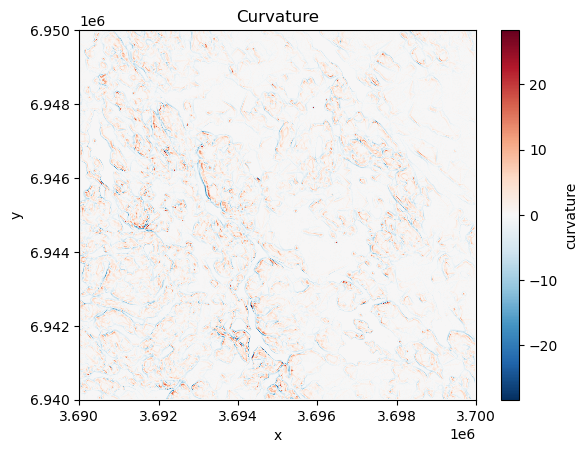

In [6]:
data["curvature"] = xrspatial.curvature(data["elevation"])
data["curvature"].plot()
plt.title("Curvature");

_**Figure 7.X.** Curvature describes the rate of change in the slope._

The map reveals that vast majority of the surface in our study area is straight having value of 0. However, few places can be spotted at the central and western parts of the region that show surfaces curwing upwards (red color) and downwards (blue color). These places tend to be located close to the areas with highest elevation values in this specific region. 


### Hot and cold spots

Hot and cold spots identify statistically significant hot spots and cold spots in an input raster. A statistically significant hot spot means that a given pixel has a high value and is surrounded by other high values. Thus, it is a similar measure to local spatial autocorrelation (LISA) although hot/cold spot analysis focuses on identifying only high-high and low-low areas, where as LISA also identify outliers (high values surrounded by low values). To identify hot and cold spots, we can use the `.hotspots()` function of the `xarray-spatial` that identifies hot and cold spots with varying degrees of confidence (90 %, 95 % and 99 %). To identify the hot spots, we also need to define the neighborhood (i.e. similar to moving window), that is used to compare values between the given pixel and its surrounding. We can do this by defining a `kernel` that can take different shapes, such as circle, annulus (ring-shaped) or a custom kernel. Here, we use a circle kernel with a size of five pixels (radius) and initialize it by using the `.convolution.circle_kernel()` function: 

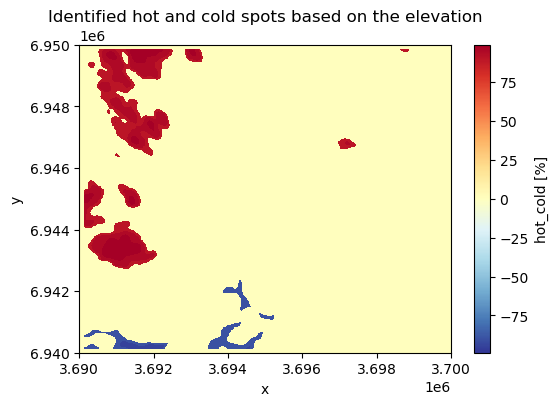

In [7]:
# Kernel size
k = 5

# Generate a kernel 
# The first two parameters with value 1 define the cell size 
# of output kernel in x and y direction
kernel = xrspatial.convolution.circle_kernel(1, 1, k)


data["hot_cold"] = xrspatial.focal.hotspots(data["elevation"], kernel)
data["hot_cold"].plot(cmap="RdYlBu_r", figsize=(6, 4))
plt.title("Identified hot and cold spots based on the elevation");

_**Figure 7.X.** Hot spots are clusters with high values surrounded by other high values._

The output map reveals that the statistically significant hot spots are located dominantly on the West and Northwest areas of the study region having areas with high elevation values while statistically significant cold spot areas are located on the Southwest. 

### Hillshade

*{term}`Hillshade`* is a visualization technique to create a 3D like (2.5D) map based on elevation data. This kind of shaded relief image simulates how the shadows are thrown upon a relief map and creates an image that resembles of how the terrain would look like from an airplane at specific time of day. The shadow is generated by blending colors related to the elevation considering the position of the sun, such as 225 degrees of azimuth (direction) and using 25 degrees altitude (angle) over the horizon. We can create and visualize a hillshade easiliy using the `.hillshade()` function of the `xarray-spatial` library that calculates an illumination value for each cell based on illumination from a specific azimuth and altitude as follows:

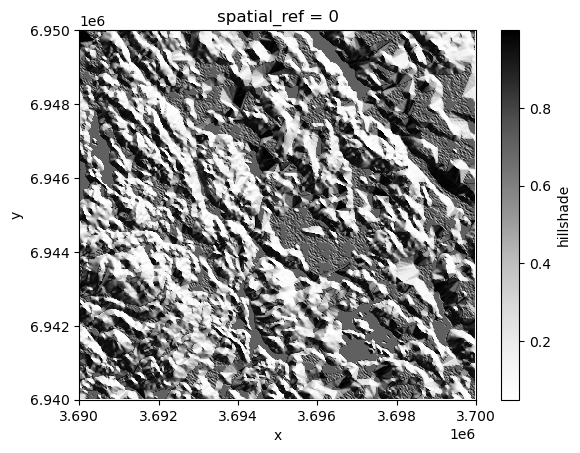

In [8]:
data["hillshade"] = xrspatial.hillshade(data["elevation"], azimuth=225, angle_altitude=25)
data["hillshade"].plot(cmap="Grays");

_**Figure 7.X.** Hillshade is a shaded relief based on the surface raster considering the illumination source angle and shadows._

From the result we can clearly see how the peaks and valleys are located in our study area. Hillshade enhances the perception of elevation and landform features in maps, helping users to better understand the terrain structure and geography. 

It is also possible to create a more realistic looking hillshade by blending a different color scheme on top of the hillshade. In the following, we show how to use `terrain` colormap for producing the hillshade using `matplotlib` functionalities. Here, we use `LightSource` that enables to create the hillshade using the `.shade()` function which enables to blend the colors in different ways: 

In [9]:
# Calculate relative height
data["relative_height"] = data["elevation"] - data["elevation"].min().item()

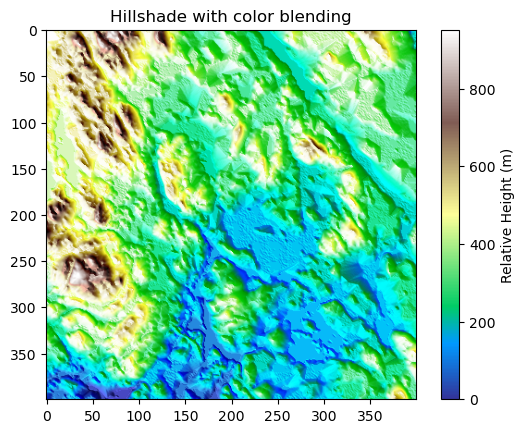

In [10]:
from matplotlib.colors import LightSource, Normalize
import matplotlib.colorbar as cbar
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots()

# The colormap to use
colormap = plt.cm.terrain

# Specifying the light source (azimuth and altitude)
ls = LightSource(azdeg=225, altdeg=25)

# Convert DataArray into numpy array
array = data["relative_height"].to_numpy()

# Normalize elevation for color mapping
norm = Normalize(vmin=np.min(array), vmax=np.max(array))

# Create hillshade
hillshade = ls.shade(array, cmap=colormap, vert_exag=1, blend_mode="overlay")
ax.imshow(hillshade)
ax.set_title("Hillshade with color blending")

# Create a ScalarMappable for colorbar
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", label="Relative Height (m)")

_**Figure 7.X.** Hillshade with color blending can give a more realistic appearance of the landscape._

The result now resembles more how the terrain might look like in real life. However, to get the most realistic appearance you might need to adjust how the colors are mapped to different heights. For instance, in the current map the areas with lighter blue shades are not exactly aligned with where the water bodies in our study area are truly located but this gives an approximation of the likelyhood of having water present in a given area (i.e. lowest altitudes).  

### Smoothing and focal statistics

As a last focal function, we introduce focal statistics that can be used e.g. to smooth the surface. This approach allows you to calculate any kind of statistics over a kernel (moving window) as illustrated earlier in the **Figure 7.XX**. In the following, we will smooth the surface by calculating the `mean` elevation over a kernel (circle) that have a size of `15` pixels. To be able to calculate focal statistics, we first need to define the `kernel` (i.e. neighborhood) which we can do by using the `.convolution.circle_kernel()` function as follows: 

In [11]:
# Kernel size
k = 15

# Generate a kernel (basically produces a boolean matrix full with numbers 1 and 0)
kernel = xrspatial.convolution.circle_kernel(1, 1, k)

Now as we have the kernel defined, we can calculate the focal statistics by using the function `.focal.focal_stats()` of the `xarray-spatial` library. As input, the function takes the elevation values, the pre-defined `kernel` as well as the statistics function (here `"mean"`) that we want to apply:

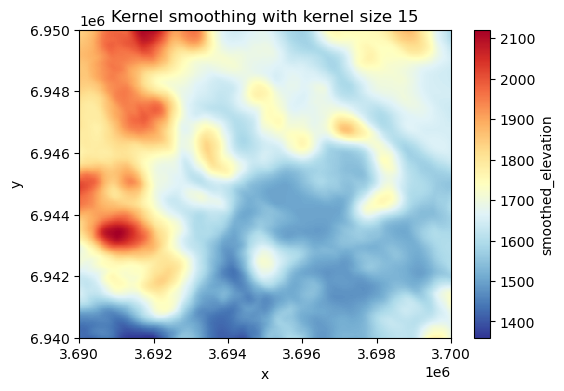

In [12]:
# Smoothen the surface
data["smoothed_elevation"] = xrspatial.focal.focal_stats(
    data["elevation"], kernel, stats_funcs=["mean"]
)

data["smoothed_elevation"].plot(cmap="RdYlBu_r", figsize=(6, 4))
plt.title("Kernel smoothing with kernel size 15");

_**Figure 7.X.** Smoothed surface based on the average elevation of 15 neighboring cells at each pixel._

As a result we got a smoothed surface where the value for each pixel is based on the average of the neighborhood surrounding the given pixel. This evens out the local variance in the elevation data and highlights the high and low elevation areas. The result looks a bit blurred because we are averaging values across relatively large neighborhood. You can adjust the appearance by using a different kernel size. The larger the kernel, the more the data is smoothed (i.e. generates more blurriness). 

## Local operations

Local functions operate between multiple raster layers and apply functions on a cell-by-cell basis between them. The figure **7.XX** illustrates a local sum based on two raster layers. When calculating a local sum, the pixel values in matching positions are summed together which generates the output raster layer. In our example, e.g. the pixel values `3` and `6` become `9` in the output layer after they are summed. In a similar manner as with focal functions that we demonstrated earlier, you can apply any mathematical function to the data (multiply, divide, etc.). Notice that in case there are NoData values (None) present in either of the input rasters, the pixel value in the output layer will also be None by default. 

![_**Figure 7.XX.** Local functions operate on a cell-by-cell basis between two or more raster layers to produce the output layer._In this case, the output value is a sum of input pixels._](../img/local_sum.png)
_**Figure 7.XX.** Local functions operate on a cell-by-cell basis between two or more raster layers to produce the output layer. In this case, the output value is a sum of input pixels._

### Data classification

One special type of local operation often used in map algebra is data classification, also commonly called as reclassification. When reclassifying data you do not conduct calculations between multiple raster layers per se, but you apply a specific classification criteria or a set of rules for each pixel one-by-one that is used to generate the output raster layer. In the following, we will take advantage specific classification schemes, such as natural breaks, to classify our data to distinct classes. You can read more about various data classification methods in Chapter 6.10.

The goal in the following is to calculate and use different surface features to find a suitable place for building a new summer house. To do this, we will use information for example about elevation, slope and aspect of the terrain. Because the data values of these variables can vary significantly - e.g. elevation between pixels can vary hundreds of meters, while slope varies between 0-90 - it is important to reclassify these values (or normalize) in some way to make them comparable. When the variables are comparable, we can conduct calculations with them and e.g. assign different weights according the importance of specific landscape features. In our case, the criteria for finding a suitable place for a summer cottage will be based on following preferences:

- The higher the elevation, the better
- Some slope is good but not too steep
- The ridge should be pointing South (more sun)

In the following, we will classify our data into five categories using `natural breaks` classification scheme. The natural breaks classification scheme (also known as Jenks optimization) is a method used to group values into classes based on natural groupings inherent in the data. It minimizes the variance within classes and maximizes the variance between classes. In our case, we will categorize the elevation data into five classes where the highest elevation values are classified into class 5 (best) and the lowest elevation values are in class 1 (worst). To classify the data, we can use the `.classify.natural_breaks()` function of the `xarray-spatial` library as follows:

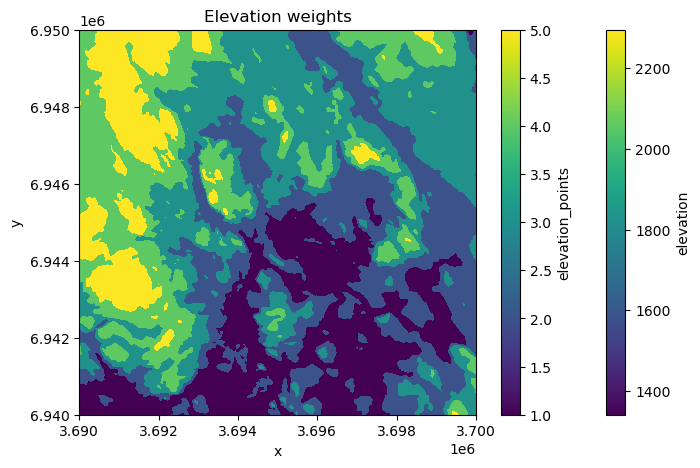

In [13]:
# Take 20 % sample to reduce the time it takes to classify
percentage = 0.2

# The sample size
n = int(round(data["elevation"].count().item() * percentage, 0))

# Reclassify elevation into 5 classes and add number 1 to the result to make the scale from 1-5
data["elevation_points"] = (
    xrspatial.classify.natural_breaks(data["elevation"], k=5, num_sample=n) + 1
)

# Plot the result
fig, ax = plt.subplots(figsize=(8, 5))
data["elevation"].plot(ax=ax)
data["elevation_points"].plot(ax=ax)
plt.title("Elevation weights");

_**Figure 7.X.** Elevation categories (k=5) based on natural breaks classification scheme._

As a result, the elevation values of each category (1-5) are now clearly visible in the map showing that the best areas according our criteria are located on the West. 

Next, we will reclassify the slope values in our data again into five classes using natural breaks, but we will weight the values in a way that the lower slope gets higher weight because we cannot build our summer house into a very steep terrain. Thus, the highest slope class gets least weight (1), while two of the lowest slope categories gets highest points (4 and 5), i.e. highest weight according our preferences. In the following, we first use the natural breaks classification to classify the slope values into five categories:

In [14]:
# Classify the slope into five categories
data["slope_nb"] = (
    xrspatial.classify.natural_breaks(data["slope"], k=5, num_sample=n) + 1
)
data["slope_nb"].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan,  1.,  1., ...,  3.,  3., nan],
       [nan,  1.,  1., ...,  3.,  3., nan],
       ...,
       [nan,  2.,  2., ...,  1.,  1., nan],
       [nan,  2.,  2., ...,  1.,  1., nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

Next, we want to reclassify the slope categories according to our preference, where the classes with lowest values get the highest points. We can reclassify data according our custom rule by using `.classify.reclassify()` function of the `xarray-spatial` library which takes the natural break classes as input data, the `bins` representing the natural breaks classes (1-5) and the `new_values` as a list of values determining how the input data is reclassified (mapped) into the output variable:

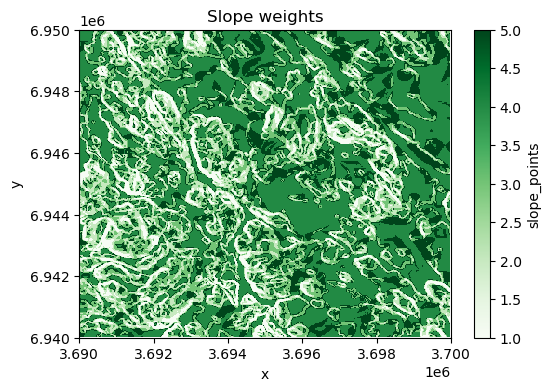

In [15]:
# Original values
bins = [1, 2, 3, 4, 5]

# New values
new_values = [4, 5, 3, 2, 1]

# Reclassify the data where lower slope gets more points
data["slope_points"] = xrspatial.classify.reclassify(
    data["slope_nb"], bins=bins, new_values=new_values
)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
data["slope_points"].plot(ax=ax, cmap="Greens")
plt.title("Slope weights");

_**Figure 7.X.** Slope categories (k=5) based on our custom classification scheme._

As a result, the map shows the best areas with dark green color according our preferences regarding the slope. 

Lastly, we want to reclassify the aspect in a way that the direction of the slope facing South (lot's of sun) gets the highest points, while the direction facing North (little sun) gets the lowest points. In the following, we apply the `.reclassify()` directly using the `aspect` variable as input data. By determining the `bins` and `new_values`, we reclassify the data according our preferences:

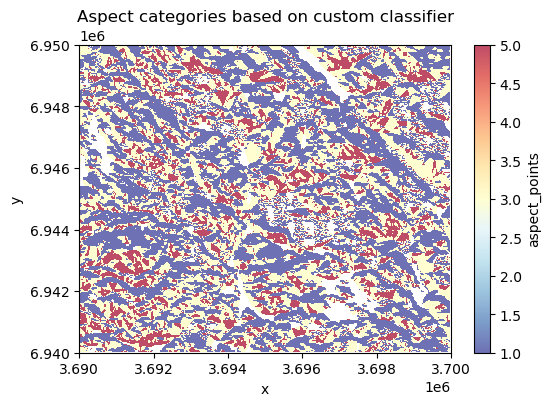

In [16]:
# Original values (aspect)
bins = [90, 150, 210, 270, 360]

# Weights given for given aspect category
new_values = [1, 3, 5, 3, 1]

# Classify
data["aspect_points"] = xrspatial.classify.reclassify(
    data["aspect"], bins=bins, new_values=new_values
)

# Make a plot
fig, ax = plt.subplots(figsize=(6, 4))
data["aspect_points"].plot(ax=ax, cmap="RdYlBu_r", alpha=0.7)
plt.title("Aspect categories based on custom classifier");

_**Figure 7.X.** Aspect categories based on a custom a custom classification scheme._

Now the South-facing areas are highlighted with red colors which are according our preferences. At this point, we have calculated various variables that are all stored in the same `xarray.Dataset`:

In [17]:
data

<xarray.Dataset> Size: 8MB
Dimensions:             (x: 400, y: 400, stats: 1)
Coordinates:
  * x                   (x) float64 3kB 3.69e+06 3.69e+06 ... 3.7e+06 3.7e+06
  * y                   (y) float64 3kB 6.95e+06 6.95e+06 ... 6.94e+06 6.94e+06
    spatial_ref         int64 8B 0
  * stats               (stats) object 8B 'mean'
Data variables:
    elevation           (y, x) float64 1MB 1.844e+03 1.843e+03 ... 1.65e+03
    slope               (y, x) float32 640kB nan nan nan nan ... nan nan nan nan
    aspect              (y, x) float32 640kB nan nan nan nan ... nan nan nan nan
    curvature           (y, x) float32 640kB nan nan nan nan ... nan nan nan nan
    hot_cold            (y, x) int8 160kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    hillshade           (y, x) float32 640kB nan nan nan nan ... nan nan nan nan
    relative_height     (y, x) float64 1MB 502.0 501.0 502.0 ... 308.0 308.0
    smoothed_elevation  (stats, y, x) float32 640kB 1.84e+03 ... 1.698e+03
    elevation_points    (y, x) float32 640kB 4.0 4.0 4.0 4.0 ... 3.0 3.0 3.0 3.0
    slope_nb            (y, x) float32 640kB nan nan nan nan ... nan nan nan nan
    slope_points        (y, x) float32 640kB nan nan nan nan ... nan nan nan nan
    aspect_points       (y, x) float32 640kB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area

Now we can use some of these variables and do a local operation in which we use the weights of our three variables of preference (elevation, slope and aspect) to calculate a suitability index that informs us about the best possible places to build a new summer house. At this stage, we can still determine that we want to give more weight to one of these variables, the aspect, as we really would like to find a place where the sun is nicely visible most of the day. To do this, we can specify that the aspect is the most important feature in our decision making getting 60 % of the total weight of these input features, while elevation and slope both receive 20 % of the weight. To calculate the suitability index, we can conduct a simple mathematical calculation (a local operation) where the points for each landscape feature are multiplied according our weighting scheme and then summed together as follows:

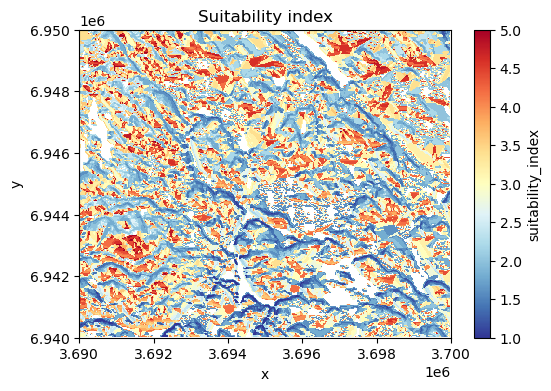

In [18]:
# Calculate the suitability index by weighting the "points" given for different layers
data["suitability_index"] = (
    data["elevation_points"] * 0.2
    + data["aspect_points"] * 0.6
    + data["slope_points"] * 0.2
)

# Plot the suitability index
data["suitability_index"].plot(cmap="RdYlBu_r", figsize=(6, 4))
plt.title("Suitability index");

_**Figure 7.X.** Suitability index calculated based on elevation, aspect and slope._

Nice! Now we have a map that shows the most suitable areas to build or buy a summer house in the region, highlighted with red color. This was a simple example showing how map algebra (focal and local operations) can be used to help in practical decision making. In a similar manner, it is easy to change the weighting scheme how the importance of different factors are considered and how a single landscape feature is weighted in the final model. You can find more examples of using local operations in Chapter 7.6 that shows how map algebra can be used when working with multiband satellite data and geospatial timeseries data spanning multiple years.

## Global operations

In map algebra, global functions are operations where the output value of each cell depends on the entire dataset or a large spatial extent, not just local neighbors. These functions are used to analyze patterns, relationships, and spatial influences across the whole raster. Global functions are often used to calculate statistical summaries of the data, e.g. maximum or average elevation in the whole region, or to conduct a viewshed analysis that shows how different areas in the region are visible from a given location. 

### Statistical summaries

Calculating statistical summaries based on all the values in a given raster is one of the most typical global operations in map algebra and typically one of the first explorative steps that you want to do when working with new data. We can easily calculate statistical summaries, such as minimum, maximum, mean, median or standard deviation based on the input data as follows:

In [19]:
minimum = data["elevation"].min().item()
print(f"Minimum elevation in the data: {minimum} meters.")

Minimum elevation in the data: 1342.0 meters.


In [20]:
maximum = data["elevation"].max().item()
print(f"Maximum elevation in the data: {maximum} meters.")

Maximum elevation in the data: 2294.0 meters.


In [21]:
mean = data["elevation"].mean().item()
print(f"Mean elevation in the data: {mean} meters.")

Mean elevation in the data: 1663.44648125 meters.


In [22]:
median = data["elevation"].median().item()
print(f"Median elevation in the data: {median} meters.")

Median elevation in the data: 1649.0 meters.


In [23]:
standard_deviation = data["elevation"].std().item()
print(f"Standard deviation of the elevation: {standard_deviation} meters.")

Standard deviation of the elevation: 147.3785525805685 meters.


Calculating these kind of summaries of the data are extremely useful to describe the data and get a basic understanding of it. Statistical summaries (in addition to visualizations) can reveal e.g. if there are something weird happening in the data, such as if there are any extreme outliers. 

### Viewshed analysis

Viewshed analysis is another map algebra technique (a global operation) which can be used to identify areas of a landscape that are visible from a specific location considering the surrounding terrain. Viewshed can be calculated based on the elevation data by selecting one or more observer points from where the visibility is analyzed based on the line of sight between the observer and every other cell in the raster (**Figure 7.XX**). If the terrain obstructs the view (e.g. mountains block the view), the cell is marked as not visible from the given observation point, and if not, the cell is visible. Viewshed analysis is relevant technique for various application areas, such as landscape assessment and telecommunications planning related to finding suitable places to place antennas. 

![_**Figure 7.XX.** Viewshed is calculated from the given observer location based on line of sight (dashed lines)._](../img/viewshed-analysis.png)

_**Figure 7.XX.** Viewshed is calculated from the given observer location based on line of sight (dashed lines)._

We can easily calculate a viewshed based on the elevation data using the `xarray-spatial` library. First, we need to define the observer location. Here, we use the center point of our raster as the observer point. To find the centroid of the raster, we can take advantage the `.rio.bounds()` function which returns the extent of the raster and then convert these coordinates into a `shapely` Polygon using the `box()` function. After this, we can easily extract the centroid and its coordinates as well as make a `GeoDataFrame` out of the centroid:

In [24]:
from shapely import box, Point
import geopandas as gpd

# Extract the center coordinates of the raster
bbox = box(*data.rio.bounds())
xcoord = bbox.centroid.x
ycoord = bbox.centroid.y

# Create a GeoDataFrame of the centroid
observer_location = gpd.GeoDataFrame(geometry=[Point(xcoord, ycoord)], crs=data.rio.crs)

Now we have defined the location of the observer for our analysis but we still need to define elevation from where the observer is looking the landscape. To do this, we first need to find out what is the elevation of the terrain at the location where our observer is standing. We can do this by using the `.interp()` function that returns the value of the pixel based on given x and y coordinates:

In [25]:
# Elevation at a given point
elevation = data["elevation"].interp(x=xcoord, y=ycoord).item()
print("Elevation in the location of observer:", elevation, "meters.")

Elevation in the location of observer: 1509.25 meters.


Let's imagine that there is a bird watching tower that rises 10 meters above the ground. In the following, we assume that a person is viewing the landscape on top of this tower to improve the visibility of the landscape. To calculate viewshed from this observation point, we can use `.viewshed()` function from the `xrspatial` library as follows:

In [26]:
# Observer elevation
observer_elevation = 10

# Calculate viewshed
data["viewshed"] = xrspatial.viewshed(
    data["elevation"], x=xcoord, y=ycoord, observer_elev=observer_elevation
)

Now we have calculated the viewshed based on the observer location and elevation. Let's finally plot the results, so that we can understand how the visibility from this location looks like:

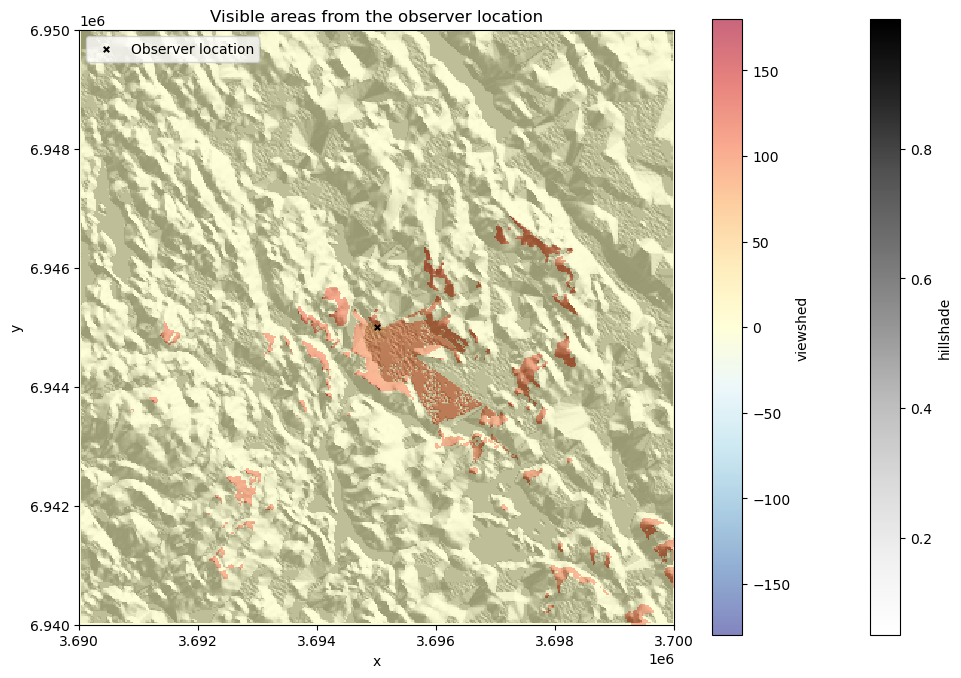

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot hillshade that was calculated earlier
data["hillshade"].plot(ax=ax, cmap="Greys")

# Plot viewshed
data["viewshed"].plot(ax=ax, cmap="RdYlBu_r", alpha=0.6)

# Observer location
observer_location.plot(
    ax=ax, color="black", marker="x", markersize=15, label="Observer location"
)

# Add legend and title
ax.legend(loc="upper left")
ax.set_title("Visible areas from the observer location");

_**Figure 7.X.** Visible areas from the observer location based on the viewshed analysis._

The resulting viewshed map shows the areas with red color that are visible from the given observer location. We can see how the visibility seem to be better towards the South from this given location which indicates that there are steep hills facing the observer location directly towards the North at this location which blocks the view in that direction. 

## Zonal operations

Zonal operation (also commonly called as zonal statistic) is a commonly used technique to summarize the values of a raster within specified zones. The zones represent areas of interest and can be defined by either a raster layer or a vector polygon layer. The fundamental goal of zonal operations is to extract statistical or categorical information about the input value layer. When the zone layer is a raster, each cell value represents a distinct zone ID, and all cells with the same value belong to the same zone (as in **Figure 7.XX**). The zone layer can also be presented in vector format as polygons, in which each polygon defines the area that serves as an individual zone. When using vector data as the zone layer, it is internally converted into a raster format (i.e. rasterized) that aligns with the input value raster in terms of resolution and alignment. Regardless of the format of the zone layer, the analysis aggregates the values of the input raster within the spatial boundaries of each zone. Similarly as with other map algebra operations, you can calculate the mean, sum, minimum, maximum, range, or majority of raster values within each zone. As an output, you typically get the statistics out for each zone as an array or table of aggregated statistics (or a Python dictionary depending on the tool you use). Alternatively, you can also get the output as a raster layer in which each cell under a given zone gets the statistical summary (e.g. mean) as an output value (as in **Figure 7.XX**).

![_**Figure 7.XX.** Zonal operation can be performed on two raster layers in which the first one defines the zones and the second one represents the values. As an output, specific statistic (e.g. mean) is calculated for each zone._](../img/zonal_average.png)

_**Figure 7.XX.** Zonal operation can be performed on two raster layers in which the first one defines the zones and the second one represents the values. As an output, specific statistic (e.g. mean) is calculated for each zone._

### Zonal statistics with raster zones

Let's start by seeing how we can do a zonal operation using a raster layer as the zones. In the following, we will use the `xarray-spatial` library to conduct the zonal statistics and continue using the same elevation data from Eastern Finland as our value layer. We have prepared a raster layer that corresponds with the elevation data in terms of resolution, extent and alignment which we can use for defining the zones. We can read this zones layer from the NetCDF file as follows:

In [28]:
zones_fp = "data/temp/raster_zones.nc"
raster_zones = xr.open_dataset(zones_fp, decode_coords="all")
raster_zones

<xarray.Dataset> Size: 1MB
Dimensions:      (x: 400, y: 400)
Coordinates:
  * x            (x) float64 3kB 3.69e+06 3.69e+06 3.69e+06 ... 3.7e+06 3.7e+06
  * y            (y) float64 3kB 6.95e+06 6.95e+06 ... 6.94e+06 6.94e+06
    spatial_ref  int64 8B ...
Data variables:
    zone_id      (y, x) float64 1MB ...
Attributes:
    AREA_OR_POINT:  Area

As we can see, the `raster_zones` layer has identical dimensions to our elevation data (i.e. 400x400) and contains one data variable called `zone_id` which contains the zone-ids for each zone. Let's investigate how many zones we have by extracting the unique values of the `zone_id`. We can easily do this by using the `.unique()` function that comes with the `numpy` library:

In [33]:
import numpy as np

np.unique(raster_zones["zone_id"])

array([1., 2., 3., 4.])

As we can see, there seems to be four zones in our data that have been marked with numbers between 1-4. The values seem to be presented in `float` data type. When doing zonal statistics with `xarray-spatial`, having floating point numbers should work fine for indicating the zone categories. However, as the documentation of `xarray-spatial` suggests to use integer values as the zone-ids, let's convert the zone-ids into integers by using the `.astype()` function:

In [35]:
raster_zones["zone_id"] = raster_zones["zone_id"].astype(int)
raster_zones["zone_id"].values

array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [3, 3, 3, ..., 4, 4, 4],
       [3, 3, 3, ..., 4, 4, 4],
       [3, 3, 3, ..., 4, 4, 4]])

Before conducting a zonal operation between the rasters, it is important to ensure that the coordinate reference system (CRS) is the same for both layers. Let's check the CRS using the `rioxarray` functionalities that we learned in Chapter 7.4:

In [36]:
raster_zones.rio.crs.to_wkt()

'PROJCS["KKJ / Finland Uniform Coordinate System",GEOGCS["KKJ",DATUM["Kartastokoordinaattijarjestelma_1966",SPHEROID["International 1924",6378388,297,AUTHORITY["EPSG","7022"]],AUTHORITY["EPSG","6123"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4123"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",27],PARAMETER["scale_factor",1],PARAMETER["false_easting",3500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","2393"]]'

In [37]:
data["elevation"].rio.crs.to_wkt()

'PROJCS["KKJ / Finland Uniform Coordinate System",GEOGCS["KKJ",DATUM["Kartastokoordinaattijarjestelma_1966",SPHEROID["International 1924",6378388,297.000000000005,AUTHORITY["EPSG","7022"]],AUTHORITY["EPSG","6123"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4123"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",27],PARAMETER["scale_factor",1],PARAMETER["false_easting",3500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2393"]]'

Great, it seems that the two raster layers share the same projection which means that we can continue calculating the zonal statistics. Let's first visualize the zones and value layer so that we understand how the zones are distributed in relation to the elevation data:

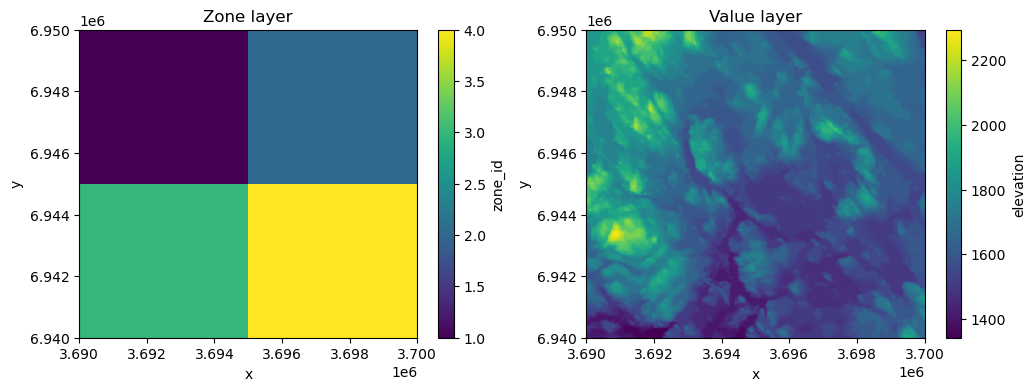

In [137]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

raster_zones["zone_id"].plot(ax=ax1)
data["elevation"].plot(ax=ax2)

ax1.set_title("Zone layer")
ax2.set_title("Value layer");

_**Figure 7.XX.** The zone layer and the elevation data that is used as value layer when calculating zonal statistics._

As we can see, our zone layer contains four values (1, 2, 3, 4) which are distributed in a way that they form simple quadrants. Thus, in our analysis we can analyze which of the zones (quadrant) has e.g. highest mean elevation. To calculate zonal statistics, we can use the `.zonal_stats()` function of the `xarray-spatial` library which can be used to calculate zonal statistics between two raster layers. The function requires the `zones` as a first parameter which will take our `"zone_id"` variable of the `raster_zones` Dataset as input, while for the `values` parameter we pass the `"elevation"` variable from the `data` value layer. With `stats_funcs` parameter, we can specify which statistics we want to calculate. In the following, we will calculate all basic summary statistics for the zones:

In [39]:
results = xrspatial.zonal_stats(zones=raster_zones["zone_id"], 
                                values=data["elevation"], 
                                stats_funcs=["mean", "max", "min", "std"])
results

zone         mean     max     min         std
0     1  1782.645700  2245.0  1499.0  131.593625
1     2  1663.077075  2000.0  1499.0   81.502421
2     3  1653.595750  2294.0  1342.0  176.641079
3     4  1554.467400  1926.0  1400.0   74.418319

As output, the `.zonal_stats()` returns a `pandas.DataFrame` that contains the statistics for each zone. From here we can see that the zone number `1` seems to have the highest average elevation while the highest peak is located under the zone `3` (2294 meters). Interestingly also the lowest elevation is found from zone 3, meaning that there is a lot of variance in elevations under this zone which is also confirmed by looking at the standard deviation which is highest at this quadrant (176 meters). 

It is also possible to return the zonal statistics as a `DataArray` which we can use to visualize the results of the zonal statistics as a map. We can e.g. calculate the average elevation of each zone and specify with `return_type="xarray.DataArray"` parameter to return the result as a raster which we can visualize:

In [49]:
results_array = xrspatial.zonal_stats(zones=raster_zones["zone_id"], 
                                      values=data["elevation"], 
                                      stats_funcs=["mean"], 
                                      return_type="xarray.DataArray")

results_array.values

array([[[1782.6457  , 1782.6457  , 1782.6457  , ..., 1663.077075,
         1663.077075, 1663.077075],
        [1782.6457  , 1782.6457  , 1782.6457  , ..., 1663.077075,
         1663.077075, 1663.077075],
        [1782.6457  , 1782.6457  , 1782.6457  , ..., 1663.077075,
         1663.077075, 1663.077075],
        ...,
        [1653.59575 , 1653.59575 , 1653.59575 , ..., 1554.4674  ,
         1554.4674  , 1554.4674  ],
        [1653.59575 , 1653.59575 , 1653.59575 , ..., 1554.4674  ,
         1554.4674  , 1554.4674  ],
        [1653.59575 , 1653.59575 , 1653.59575 , ..., 1554.4674  ,
         1554.4674  , 1554.4674  ]]])

As we can see, now the average elevation is returned for each pixel under a specific zone (i.e. similar output as in **Figure 7.XX**). We can now visualize the result easily using the standard plotting functionalities of `xarray`. In the following, we plot the result from the zonal statistics as a map and also add the contour lines of the original elevations on top of the raster:

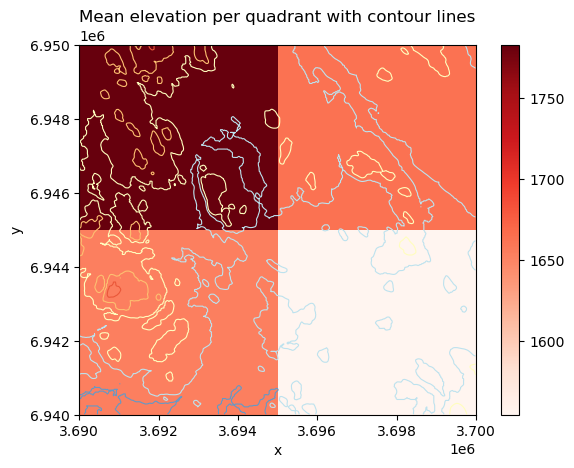

In [53]:
fig, ax = plt.subplots()

results_array.plot(ax=ax, cmap="Reds")
data["elevation"].plot.contour(ax=ax, cmap="RdYlBu_r", linewidths=0.8)
plt.title("Mean elevation per quadrant with contour lines");

_**Figure 7.XX.** The result of the zonal statistics visualized as a map including also the contour lines representing the elevations._

The result reveals that the top-left quadrant (zone 1) has the highest average elevation whereas the bottom-right corner has the lowest average elevation. This is also confirmed by the contour lines as there exists many high peaks under zone 1 and not many low-elevation areas (which are visualized with blue contour lines). The map also confirms our previous finding that the bottom-left zone (i.e. zone 3) has a lot of variance in the elevations as there are both high peaks as well as areas with low elevations under this zone. 

### Zonal statistics with vector zones

Another commonly used approach to conduct zonal statistics is to use vector data (polygons) for defining the zones. In the following, we will use `xvec` library to conduct the zonal statistics between the vector (zones) and raster layer. As an example, we focus on specific area in our study region and investigate what is the elevation difference between one of the lakes present in this area (lake *Riuttanen*) and one of the peaks next to it (*Riuttavaara*). 

To do the zonal operation, we first download data from OpenStreetMap to represent our areas of interest. In the following, we will fetch OSM data using `osmnx` library that is a handy tool to download all sorts of vector data from OpenStreetMap into a `GeoDataFrame` (more details about `osmnx` is presented in Chapter 9). We can search and download the data for the lake using its name which we pass to the `.geocode_to_gdf()` function of the `osmnx`. For the peak Riuttavaara, we need to specify the exact OSM node-id (which can be found by exploring the openstreetmap.org website) because there are multiple peaks and localities in Finland having this same name. As the peak is returned as a `Point` object, we also need to create a small polygon buffer (200 meters) around the peak to be able to use it as a zone in our analysis:

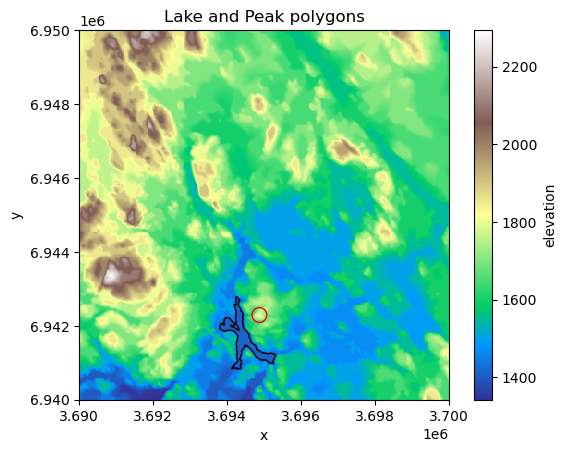

In [62]:
import osmnx as ox
from shapely import box
import pandas as pd

# Fetch lake "Riuttanen" from OSM
lake = ox.geocode_to_gdf("Riuttanen, Joensuu")
lake = lake.to_crs(crs=data.rio.crs)

# Fetch peak Riuttavaara based on OSM Node ID
peak = ox.geocode_to_gdf("N11034739930", by_osmid=True)
peak = peak.to_crs(crs=data.rio.crs)

# Create a buffer around the peak
peak["geometry"] = peak.buffer(200)

# Plot
fig, ax = plt.subplots()

data["elevation"].plot(ax=ax, cmap="terrain")
lake.plot(ax=ax, facecolor="None")
peak.plot(ax=ax, edgecolor="red", facecolor="None")
ax.set_title("Lake and Peak polygons");

_**Figure 7.X.** Two zones that are used for comparison and calculating zonal statistics._

From the map we can see where the lake and peak are located. Now as we have our zones defined, we need to combine them into a single `GeoDataFrame` which we can do easily using `pandas` as follows:

In [91]:
# Merge zones into a single GeoDataFrame
zones = pd.concat([peak, lake]).reset_index(drop=True)
zones.iloc[:, -3:]

addresstype         name                                       display_name
0        peak  Riuttavaara  Riuttavaara, Joensuu, Joensuu sub-region, Nort...
1       water    Riuttanen  Riuttanen, Joensuu, Joensuu sub-region, North ...

Now we are ready to conduct the actual zonal operation between our elevation data (raster) and the zones (vector). The `xvec` library is a handy tool to use when you need to interact between vector and raster data. It is designed for representing and working with vector data cubes (more about this in Chapter 7.6) and interact with `xarray` data structures. The `.xvec.zonal_stats()` function can be used to calculate zonal statistics. As input, we define the zones using the `geometry` parameter which accepts our vector polygons from the `.geometry` column (i.e. `GeoSeries`) as input. The `stats` parameter can be used to define the statistics that we want to calculate (mean, max, etc.). We also need to define the names of the coordinate variables of the `xarray.Dataset` that is used as input using the `x_coords` and `y_coords` parameters. The names of the coordinates in your `DataArray` can be easily found via the `.coords` attribute:

In [92]:
data["elevation"].coords

Coordinates:
  * x            (x) float64 3kB 3.69e+06 3.69e+06 3.69e+06 ... 3.7e+06 3.7e+06
  * y            (y) float64 3kB 6.95e+06 6.95e+06 ... 6.94e+06 6.94e+06
    spatial_ref  int64 8B 0

The last parameter that we specify here for the `.xvec.zonal_stats()` function is `all_touched`. This parameter specifies how the edge-cases are handled when the vector and raster intersect with each other. When conducting a zonal operation between a vector and raster layer, you very likely have situations in which the vector boundary does not perfectly align with the raster cells and the Polygons representing the zones cover only partially the raster pixels. To control how these cases should be handled, you can use the `all_touched` parameter to specify if only such pixels should be considered in the calculation in which the centroid of the pixel lies within the zone Polygon (`all_touched=False`), or if all the pixels that touch the boundary should be considered in the calculation of the zonal statistics (`all_touched=True`). In the following, we will calculate the zonal statistics considering the latter:

In [93]:
import xvec

stats_array = data["elevation"].xvec.zonal_stats(geometry=zones.geometry, 
                                                 x_coords="x", 
                                                 y_coords="y", 
                                                 stats=["mean", "max", "std"],
                                                 all_touched=True
                                                )
stats_array

<xarray.DataArray 'elevation' (geometry: 2, zonal_statistics: 3)> Size: 48B
array([[1720.87179487, 1800.        ,   46.33140348],
       [1412.74540902, 1490.        ,   11.07710681]])
Coordinates:
    spatial_ref       int64 8B 0
  * zonal_statistics  (zonal_statistics) <U4 48B 'mean' 'max' 'std'
  * geometry          (geometry) object 16B POLYGON ((3695077.0730254874 6942...
Indexes:
    geometry  GeometryIndex (crs=PROJCS["KKJ / Finland Uniform Coordinate System",GEOGCS["KKJ",DATU ...)
Attributes:
    RepresentationType:        ATHEMATIC
    STATISTICS_MAXIMUM:        2294
    STATISTICS_MEAN:           1663.44648125
    STATISTICS_MINIMUM:        1342
    STATISTICS_SKIPFACTORX:    1
    STATISTICS_SKIPFACTORY:    1
    STATISTICS_STDDEV:         147.37855258057
    STATISTICS_VALID_PERCENT:  100

As a result, we get a `DataArray` that contains a lot of information. However, the key information are the zonal statistics for each zone (i.e. a row in our `GeoDataFrame`) which is presented as the very first thing in the output as a two dimensional `array` in which there are three values (on the first row) that here represent the `mean` (1720.87), `max` (1800.0) and `std` (46.3) of the first feature in our `zones` vector dataset. To make this information a bit easier to read and use, we can also access the calculated statistical values as well as the names of the statistics that we used as follows:

In [94]:
# Names of the statistics
stat_names = stats_array.zonal_statistics.values

# Zonal statistics
stat_values = stats_array.values


print(stat_names)
print(stat_values)

['mean' 'max' 'std']
[[1720.87179487 1800.           46.33140348]
 [1412.74540902 1490.           11.07710681]]


By using these attributes, we can now easily create a `DataFrame` out of the results and make a table join with the input `GeoDataFrame` to link the calculated zonal statistics with our `zones` as follows:

In [95]:
stats = pd.DataFrame(stat_values, columns=stat_names)
stats

mean     max        std
0  1720.871795  1800.0  46.331403
1  1412.745409  1490.0  11.077107

In [96]:
zones = zones.join(stats)
zones.iloc[:, -6:]

addresstype         name                                       display_name  \
0        peak  Riuttavaara  Riuttavaara, Joensuu, Joensuu sub-region, Nort...   
1       water    Riuttanen  Riuttanen, Joensuu, Joensuu sub-region, North ...   

          mean     max        std  
0  1720.871795  1800.0  46.331403  
1  1412.745409  1490.0  11.077107

Perfect! Now we can easily compare these two areas to each other and e.g. calculate the elevation difference between the lake and the peak as follows:

In [97]:
# What is the maximum difference in elevation between peak and lake?
difference = zones.at[0, "mean"] - zones.at[1, "mean"]
print(f"Elevation difference between the peak and lake: {difference:.0f} m.")

Elevation difference between the peak and lake: 308 m.


We can see that the peak seem to be located more than 300 meters above the lake, meaning that you probably have a good view covering the whole lake if you would be standing on top of this peak. 

In a similar manner as in the examples above, you can conduct zonal statistics between vector and raster layer, or two raster layers, using any kind of data. Zonal operations are commonly used for tasks such as land cover analysis, habitat suitability modeling, or watershed management, where summarizing raster information (e.g. elevation, rainfall, biomass, moisture etc.) over administrative regions or natural boundaries is essential. 

## Incremental operations

Lastly, we will introduce incremental operations that are one category of techniques in map algebra. Incremental operations involve multiple stages of calculation based on the input raster in which the calculations are conducted step-by-step. As an example, we will introduce an application in which the goal is to find an optimal path across a given surface based on the cost of moving from one cell to the other. For instance, the elevation data can be considered as a good proxy for difficulty in moving across a landscape (e.g. when walking). Thus, we can treat the elevation data as our *{term}`cost surface`* and when finding the optimal path across the surface, we aim to minimize the cost when moving from A to B. In other words, we aim to travel across the surface in a way that we avoid climbing the hills and prefer moving across as flat surface as possible. 

Similarly, in flow accumulation analysis used for hydrological modelling (see Chapter 12), incremental operations enable updates to the accumulation grid when minor changes occur in the input elevation data. For instance, if a localized area of a digital elevation model is edited to reflect a new drainage channel or a filled depression, an incremental flow accumulation process would update the flow direction and accumulation values only downstream of the altered cells. 

### Least-cost path calculation based on a raster cost surface

Least-cost path calculation is one of the most typical incremental operations in map algebra. To be able to calculate least-cost path based on a given raster, we first need to have a cost surface which is a raster representation used in the incremental operations in which each cell value indicates the cost required to traverse that cell. Cost surfaces are widely used in spatial analysis to model and calculate the optimal path or accumulated cost between locations, taking into account various environmental factors influencing the traversal across the surface, such as terrain or land use. Cost surfaces are widely used in applications such as route optimization, habitat connectivity, and emergency response planning. 

Before it is possible to conduct a least-cost path calculation, it is necessary to have a raster that represents the costs. The cost surface can basically represent any meaningful information (e.g. time, energy, money, or difficulty) but in our case we use the elevation data as a simple indicator of difficulty - the higher the elevation, the more effort it takes to travel across that area. When working with cost surfaces, it is also common that specific areas cannot be crossed at all, i.e. they are treated as barriers in the analysis. For instance, you might want to treat water areas as barriers because you most likely do not want to cross water bodies when traveling across the landscape, although in principle you could do that with very high effort/cost (swimming). 

In Python, we can use the `xarray-spatial` library and its function `.a_star_search()` to conduct least-cost path analysis based on raster data. Let's start by creating a couple of points that we use in our analysis as an origin and destination locations and also create a straight line between these points:

In [231]:
from shapely import Point, LineString

orig_point = Point(3691000, 6941500)
dest_point = Point(3698500, 6947000)

origin = gpd.GeoDataFrame(geometry=[orig_point], crs=data.rio.crs)
destination = gpd.GeoDataFrame(geometry=[dest_point], crs=data.rio.crs)

line = gpd.GeoDataFrame(geometry=[LineString([orig_point, dest_point])], crs=data.rio.crs)

To make our data more understandable, let's create a couple of maps to demonstrate where our points are located in relation to the elevation data that we use as a cost surface:

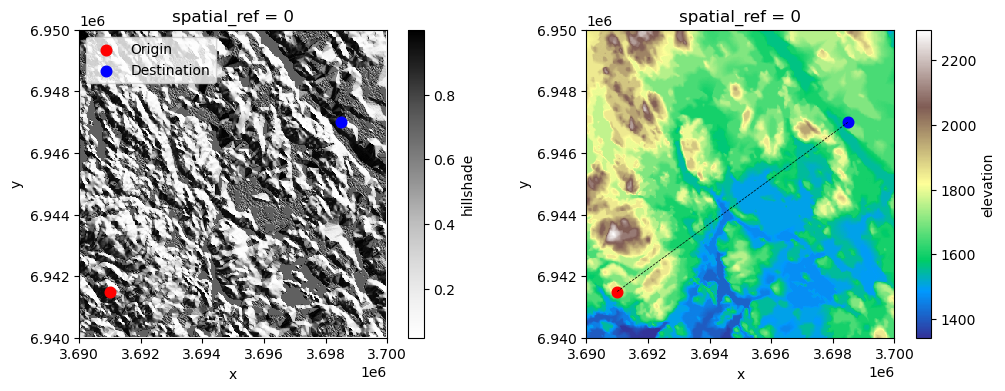

In [237]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

data["hillshade"].plot(ax=ax1, cmap="Greys")
data["elevation"].plot(ax=ax2, cmap="terrain")

origin.plot(ax=ax1, color="red", markersize=58, label="Origin")
origin.plot(ax=ax2, color="red", markersize=58, label="Origin")
destination.plot(ax=ax1, color="blue", markersize=58, label="Destination")
destination.plot(ax=ax2, color="blue", markersize=58, label="Destination")
line.plot(ax=ax2, color="black", linestyle="--", lw=0.5)

ax1.legend(loc="upper left");

_**Figure 7.X.** Origin and destination points that are used to find the least-cost path across the surface._

As we can see from the maps, our origin and destination are located quite far away from each other and the terrain between those places includes various hills with high elevation as well as low-elevation areas which include water areas. Let's start our analysis by defining the barriers that should be considered when finding the optimal path. In our example, we consider the water areas to be all pixels where the elevation is below 1580 meters (thus all pixels with shades of blue color in the map on the right). As we can see, there are wide areas at the center of the map that cannot be crossed according our criteria.  Notice that the criteria we use here for defining the water areas does not reflect the reality in our study region, but we use this rule here as a simple way to demonstrate the effect of barriers. 

Let's start our least-cost path analysis by extracting the latitude-longitude coordinates (i.e. y and x) of our origin and destination points which are needed as input in the least-cost path analysis.

In [240]:
origin_latlon = (origin.geometry.y.item(), origin.geometry.x.item())
destination_latlon = (destination.geometry.y.item(), destination.geometry.x.item())

print("Origin:", origin_latlon)
print("Destination:", destination_latlon)

Origin: (6941500.0, 3691000.0)
Destination: (6947000.0, 3698500.0)


Next, we define the barriers which should be provided as a list of values in the cost-raster that cannot be used when finding the optimal path. Thus, in our case we can simply create a list of values that represent all the elevations that cannot be crossed. In the following, we create a simple 1D `np.array` that contains all values between 1342-1581 in which the lowest number corresponds to the minimum elevation in our data:

In [257]:
lowest_elevation = int(data["elevation"].min().item())

barriers = np.array(list(range(lowest_elevation, 1581)))
barriers

array([1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352,
       1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363,
       1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374,
       1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385,
       1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396,
       1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407,
       1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418,
       1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429,
       1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440,
       1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451,
       1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462,
       1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473,
       1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484,
       1485, 1486, 1487, 1488, 1489, 1490, 1491, 14

Now we are ready to run the least-cost path analysis using the `xarray-spatial` library. As mentioned previously, the `.a_star_search()` function can be used to find the optimal path from A to B across the given cost-surface raster (here elevation) considering the barriers. As the name implies, this function uses a specific path finding algorithm (also commonly used in network analysis) called A\* which starts from the origin pixel and visits the neighboring cells in an incremental manner step-by-step keeping track of the cost that it takes to move from one cell to another until it reaches the destination cell. The A\* algorithm uses heuristics to direct its traversal across the surface (typically) based on the Euclidean distance between the origin and destination which means that the movement is prioritized towards the directions that shortens the straight-line distance between the origin and destination. This is done to avoid the need to visit every single pixel in the cost-surface which improves the performance (calculation speed) of the algorithm. 

In the following, we will calculate the least-cost path across our elevation data by using the elevation data as the `surface`, while the latitude-longitude coordinate tuples of our origin and destination are passed for the `start` and `goal` parameters. Lastly, the `barriers` parameter is used to pass our list of values that should be avoided while finding the optimal route between the two locations:

In [278]:
least_cost_path = xrspatial.a_star_search(
    surface=data["elevation"], 
    start=origin_latlon, 
    goal=destination_latlon,
    barriers=barriers
)
print(type(least_cost_path))
least_cost_path.values

<class 'xarray.core.dataarray.DataArray'>


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

As a result, we get a `DataArray` that represents the optimal path. As we can see, there are many `nan` values in the array which is because only the pixels that are part of the optimal path will contain numerical data. We can confirm this by visualizing the least-cost path as a map:

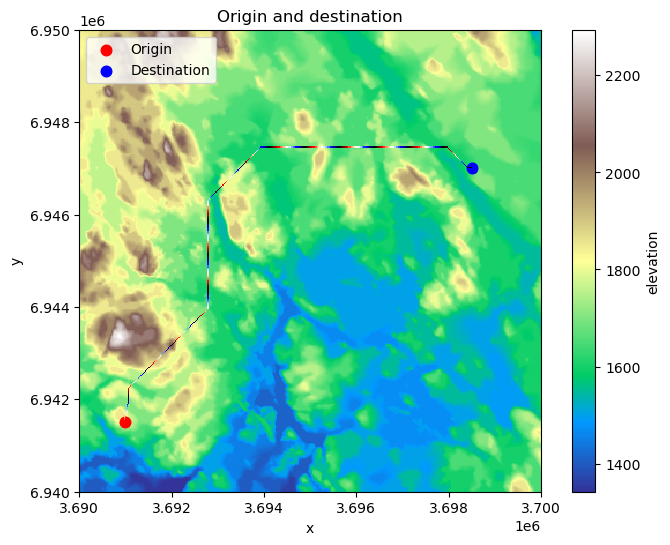

In [279]:
fig, ax = plt.subplots(figsize=(8,6))

# Elevation, origin and destination
data["elevation"].plot(ax=ax, cmap="terrain")
origin.plot(ax=ax, color="red", markersize=58, label="Origin")
destination.plot(ax=ax, color="blue", markersize=58, label="Destination")

# Plot the optimal route
least_cost_path.plot(ax=ax, cmap="flag", add_colorbar=False)

ax.legend(loc="upper left")
plt.title("Origin and destination");

_**Figure 7.X.** The calculated least-cost path from origin to destination based on A\* algorithm._

As a result, we have now found an optimal (least-cost) route across the surface that seem to make sense: The water areas which we marked as barriers in the analysis were avoided entirely and the route prioritizes pixels that are "easier" to travel, i.e. the lower elevation areas that are colored with green. 

This simple example of an incremental operation demonstrates how take advantage of map algebra to make relatively sophisticated analysis to help decision making. Naturally, the cost-surface that we use here is very simplistic but with some additional or alternative data, as well as more carefully considered rules, it would be possible to make the analysis more realistic. Similar approaches have been used e.g. to calculate travel times at a global level from every location (pixel) in the world to the closest city at 1 km resolution ({cite}`Weiss_2018`) which can be highly useful information to understand how easily people can access key services that they need (e.g. healthcare), or to understand the impacts of humans to nature ({cite}`laurance_2002`). In addition, the incremental operations and these kind of raster surfaces can be used for various other applications as well, such as conducting watershed analysis which we will cover more in detail in the Chapter 12. 